In [9]:
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import pickle
import os


In [10]:
# Read data
df = pd.read_csv('../data/openw_irradiation_2005_2020.csv', parse_dates=['day'])
df.drop(['day', 'weather_id'], axis = 1, inplace=True)

display(df.head())
display(df.tail())

,year,month,temp ºC,feels_like ºC,pressure,humidity %,clouds %,visibility,wind_speed m/s,irrad kwh/m2
0,2005,1,21.041290,21.445806,1015.193548,86.161290,71.290323,7741.935484,3.296774,135.96
1,2005,2,20.410000,20.680000,1016.750000,83.250000,46.428571,8714.285714,3.589286,162.91
2,2005,3,20.905806,21.217097,1018.161290,82.935484,54.354839,8129.032258,3.403226,138.82
3,2005,4,20.427667,20.655000,1020.000000,81.533333,56.166667,8017.241379,3.131667,133.84
4,2005,5,18.132258,18.061290,1020.709677,78.903226,45.000000,7933.333333,2.178065,117.79


,year,month,temp ºC,feels_like ºC,pressure,humidity %,clouds %,visibility,wind_speed m/s,irrad kwh/m2
187,2020,8,16.638065,16.261935,1020.225806,75.419355,33.870968,9193.548387,3.257742,133.68
188,2020,9,20.469333,20.342333,1019.166667,68.500000,46.000000,8300.000000,3.676333,151.77
189,2020,10,19.894839,19.894839,1014.096774,76.483871,54.838710,8919.354839,3.698710,165.86
190,2020,11,19.398000,19.384000,1017.633333,75.433333,51.000000,9133.333333,4.270667,185.15
191,2020,12,21.540000,21.842581,1016.193548,79.064516,51.451613,9096.774194,3.503226,166.73


In [11]:
#features and target
X = df.drop(['irrad kwh/m2'], axis=1)
y = df[['irrad kwh/m2']]

In [12]:
#train test split
tscv = TimeSeriesSplit(n_splits=5)

# Loop folds
for train_index, test_index in tscv.split(df['year'], df['month']):
    
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [13]:
#default parameters
xgb.XGBRegressor().get_params()

{'objective': 'reg:squarederror',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'gamma': None,
 'gpu_id': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [14]:
xg_reg = xgb.XGBRegressor()
# training the model
xg_reg.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [15]:
# predicting
xgb_preds = xg_reg.predict(X_test)
xgb_preds

array([124.22742 , 101.31559 , 124.51932 , 119.676254, 124.86741 ,
       144.69489 , 142.97636 , 182.0296  , 204.96806 , 160.84007 ,
       156.02353 , 150.96278 , 120.94711 , 111.34946 , 105.19767 ,
       115.812325, 141.3269  , 165.46635 , 149.18074 , 163.59366 ,
       155.15536 , 141.22734 , 153.0125  , 129.02483 , 104.78746 ,
        97.033005, 104.83994 , 114.14503 , 165.4466  , 146.406   ,
       155.81555 , 167.59566 ], dtype=float32)

In [16]:
print('R score is :', r2_score(y_test, xgb_preds))

R score is : 0.744987092266037


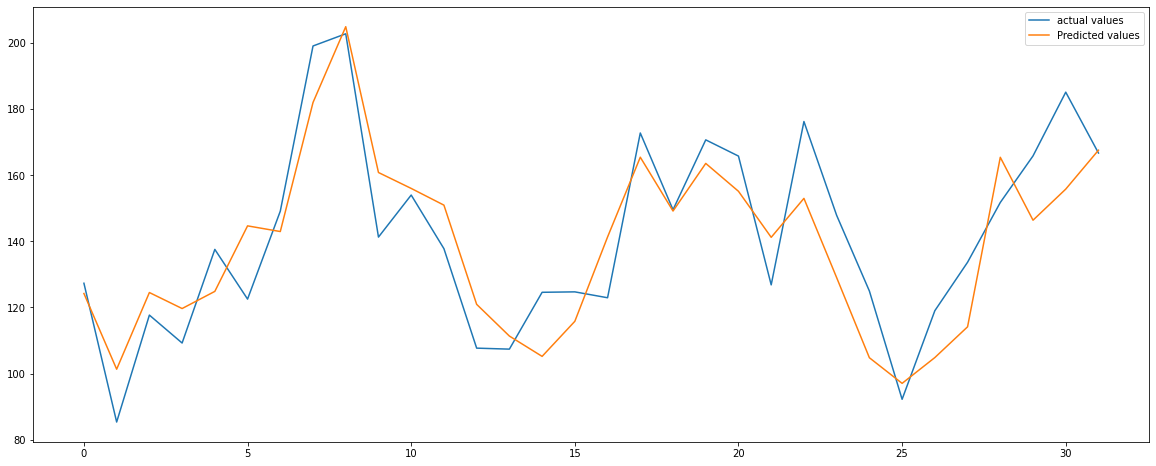

In [17]:
plt.figure(figsize=(20, 8))
# plotting the graphs
plt.plot([i for i in range(len(y_test))],y_test, label="actual values")
plt.plot([i for i in range(len(y_test))],xgb_preds, label="Predicted values")
# plt.axis('off')
# showing the plotting
plt.legend()
plt.show()

In [18]:
print(f'A predição foi de {len(xgb_preds)} meses, ou seja, {int(len(xgb_preds)/12)} anos e {len(xgb_preds)%12} meses.')

A predição foi de 32 meses, ou seja, 2 anos e 8 meses.


### Salvando o modelo

In [21]:
# Create a folder to save the models in weatherprediction folder if it doesn't exist
if not os.path.exists('../models'):
    os.makedirs('../models')

In [23]:
# Save the model as xgb_irradiation.pkl if it doesn't exist
if not os.path.exists('../models/xgb_irradiation.pkl'):
    pickle.dump(xg_reg, open('../models/xgb_irradiation.pkl', 'wb'))


### Próximos passos:
- GridSearchCV para melhorar o modelo?

### Dúvida:
- Tem como estabelecer uma quantidade de previsões? 